# 54.11 PROJECT. Анализ результатов A/B-теста
Туристическая фирма планирует запустить новую акцию, чтобы продать как можно больше туров. Были разработаны два варианта варианта посадочной страницы и проведен A/B-тест.
Требуется оценить результаты A/B-теста.
Требуется проверить какая из страниц работает лучше в разрезе конверсии, выручки и среднего чека.

Уровень статистической значимости - 0,05.

Варианты стоимости туров (руб.):
- 10000 
- 60000 
- 100000 
- 150000 
- 200000

## Импорт необходимых библиотек и модулей и чтение датасета.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 4)
import matplotlib.pyplot as plt
#%matplotlib inline

Импортируем таблицу с исходными данными:

In [2]:
df_initial=pd.read_csv('C:/New_life/DataAnalytics/Python/54_11_PROJECT/ab_data.csv',index_col=0)
df=df_initial.copy()
display(df)
display(df.info())

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
...,...,...,...,...,...
294476,697314,2021-01-15,A,0,0
294477,715931,2021-01-16,B,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 13.5+ MB


None

## 1. Первичный анализ и обработка датасета.
   В рамках этой задачи вам предстоит:
   - привести столбцы к корректным типам данных;
   - убедиться, что данные по обеим группам представлены за одинаковый период (визуализировать);
   - проверить корректность распределения участников теста;
   - проверить различие в группах;
   - проверить пересечение аудитории в группах;
   - определить по группам ряд показателей (количество пользователей, количество покупок, выручку, конверсию, средний чек);
    - посмотреть, как распределяются суммы покупок (здесь необходимо повизуализировать);
    - сделать первичные выводы.

### Предварительные проверки и подготовка датафрейма

Убедимся, что значения столбца 'purchase' принимают исключительно значения 0 и 1, а значения столбца 'price' - из каталога цен на туры.

In [3]:
display(df['purchase'].value_counts())
pd.set_option('display.max_rows', 10)
display(df['price'].value_counts())

0    259241
1     35237
Name: purchase, dtype: int64

0         259241
10000      10510
100000      7170
60000       7091
150000      7008
200000      3458
Name: price, dtype: int64

ВЫВОД: Значения столбцов соответствуют заявленным вариантам.

Приведем столбец 'date' к типу datetime:

In [4]:
df['date']=pd.to_datetime(df['date'])
pd.set_option('display.max_rows', 4)
display(df)
display(df.info())

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
...,...,...,...,...,...
294476,697314,2021-01-15,A,0,0
294477,715931,2021-01-16,B,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.5+ MB


None

### Убедимся, что данные по обеим группам представлены за одинаковый период:

In [5]:
df_ab_grouped=df.groupby(['group'],axis=0, as_index=False)
date_min_max=df_ab_grouped['date'].agg(['min','max']).rename(columns={'min':'earliest date', 'max':'latest date'})
#date_min_max=df.groupby(['group'],axis=0, as_index=False)['date'].aggregate({'date':'min', 'date':'max',}) 
display(date_min_max)
print('Дата начала тестирования совпадает для групп А и B?       - ', date_min_max.loc['A']['earliest date']==date_min_max.loc['B']['earliest date'])
print('Дата завершения тестирования совпадает для групп А и B?   - ', date_min_max.loc['A']['latest date']==date_min_max.loc['B']['latest date'])

,earliest date,latest date
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


Дата начала тестирования совпадает для групп А и B?       -  True
Дата завершения тестирования совпадает для групп А и B?   -  True


ВЫВОД: Даты начала и завершения тестирования совпадают для групп А и В.

Построим таблицу и на ее основе диаграмму, показывающие количество участников теста по дням:

In [6]:
df_date_grouped=df.copy()
df_date_grouped['user_id2']=df_date_grouped['user_id']  # дубликат колонки user_id
df_date_grouped=df.groupby(['date','group'], axis=0, as_index=False)
date_vs_users=df_date_grouped['user_id'].aggregate({'user_id':'count','user_id2':'nunique'}) \
    .rename(columns={'user_id':'users cnt', 'user_id2':'unique users cnt'})
display(date_vs_users)

,date,group,users cnt,unique users cnt
0,2021-01-02,A,2894,2894
1,2021-01-02,B,2889,2889
...,...,...,...,...
44,2021-01-24,A,3811,3810
45,2021-01-24,B,3727,3727


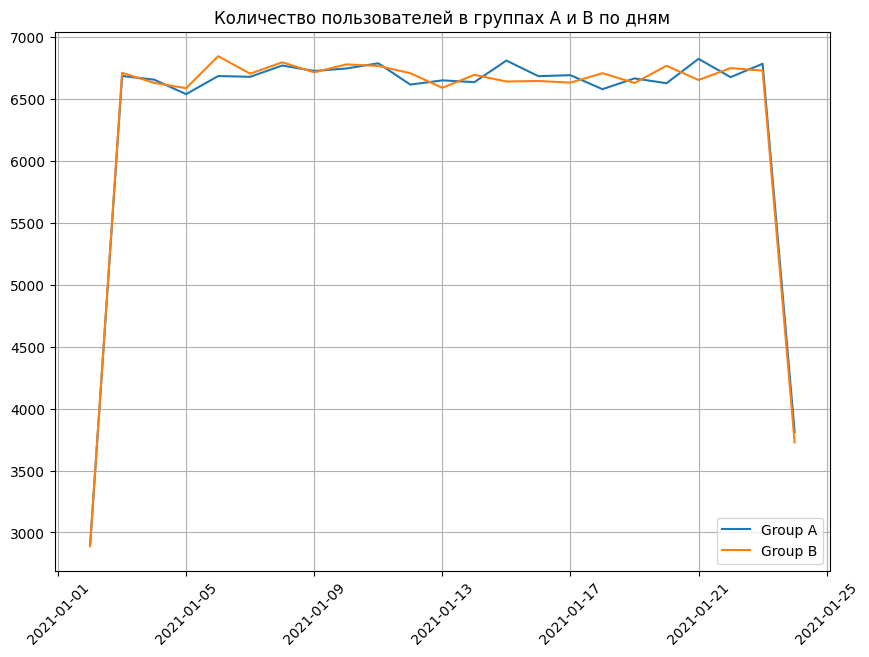

In [7]:
plt.figure(figsize=(10,7)) # Задаём размер графика
plt.plot(date_vs_users[date_vs_users['group']=='A']['date'], date_vs_users[date_vs_users['group']=='A']['users cnt'], label='Group A') # label — подпись данных на графике
plt.plot(date_vs_users[date_vs_users['group']=='B']['date'], date_vs_users[date_vs_users['group']=='B']['users cnt'], label='Group B') # label — подпись данных на графике
#plt.plot(date_vs_users[date_vs_users['group']=='A']['date'], date_vs_users[date_vs_users['group']=='A']['unique users cnt'], label='Group A') # label — подпись данных на графике
#plt.plot(date_vs_users[date_vs_users['group']=='B']['date'], date_vs_users[date_vs_users['group']=='B']['unique users cnt'], label='Group B') # label — подпись данных на графике
plt.title('Количество пользователей в группах А и В по дням') # Название графика
plt.xticks(rotation = 45) # Разворот названия дат на оси X на 45 градусов
plt.legend() # Выводим название, указанное в label в plt.plot() на график
plt.grid(True) # Выводим сетку на график
plt.show() # Выводим график на экран


ВЫВОД: За весь период тестирования не наблюдается дней, когды бы отсутствовали пользователи из какой-либо группы.

**ВЫВОД**: данные по обеим группам представлены за одинаковый период.

### Проверим корректность распределения участников теста
Судя по диаграмме выше, участники достаточно равномерно распределены по двум группам.
Для уверенности, определим это в числах, а также выясним нет ли попаданий одного и того же пользователя в обе группы.

#### Проверка корректности количественного распределения пользователей по группам в целом за период

In [8]:
a_users_cnt = date_vs_users[date_vs_users['group']=='A']['users cnt'].sum()
print('Общее количество визитов в группе А          :   ', a_users_cnt)
b_users_cnt = date_vs_users[date_vs_users['group']=='B']['users cnt'].sum()
print('Общее количество визитов в группе В          :   ', b_users_cnt)
print('По количеству визитов группа А составляет    :   ', \
    round(a_users_cnt / b_users_cnt * 100, 3), '%' ' от группы B')
print('По количеству визитов группа B составляет    :   ', \
    round(b_users_cnt / a_users_cnt * 100, 3), '%' ' от группы A')

Общее количество визитов в группе А          :    147202
Общее количество визитов в группе В          :    147276
По количеству визитов группа А составляет    :    99.95 % от группы B
По количеству визитов группа B составляет    :    100.05 % от группы A


**ВЫВОД**: В целом распределение участников теста между группами корректно, разница составляет 0.5%.

#### Убедимся что нет пересечения аудитории в группах - нет пользователей, попавших в обе группы.

In [9]:
pd.set_option('display.max_rows', 4)
print('Исходная таблица:')
display(df)
users_a=set(df[df['group']=='A']['user_id'])    # множество пользователей в группе А
users_b=set(df[df['group']=='B']['user_id'])    # множество пользователей в группе А
print('Множество пользователей в группе А совпадает с множеством пользователей в группе B ?   - ' \
    , users_a==users_b, '\n')
users_ab=users_a.intersection(users_b)          # множество пользователей, попавших в обе группы
print('Множество пользователей, попавших в обе группы   :   ', users_ab)
print('Количество пользователей в группе А              :   ', len(users_a))
print('Количество пользователей в группе B              :   ', len(users_b))
print('Количество пользователей, попавших в обе группы  :   ', len(users_ab))
print('Процент пользователей, попавших в обе группы,\n       от общего числа уникальных пользователей  :   ' \
    , round(len(users_ab) / (len(users_a) + len(users_b)) * 100, 2))

Исходная таблица:


,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
...,...,...,...,...,...
294476,697314,2021-01-15,A,0,0
294477,715931,2021-01-16,B,0,0


Множество пользователей в группе А совпадает с множеством пользователей в группе B ?   -  False 

Множество пользователей, попавших в обе группы   :    {843786, 868364, 737298, 843797, 630805, 843802, 761882, 933918, 688167, 827432, 835630, 860206, 778288, 843832, 802877, 745536, 663619, 680003, 811077, 811079, 639059, 720982, 630871, 835673, 835675, 630887, 721002, 761965, 639090, 819318, 786565, 778375, 712853, 868503, 934040, 671902, 811196, 934076, 770242, 917708, 680144, 811222, 893145, 631008, 712930, 852215, 778488, 884985, 901376, 663810, 827654, 917767, 688390, 942353, 860441, 745756, 721188, 917799, 942375, 844083, 721208, 680251, 655678, 704832, 835905, 696642, 803145, 639310, 844114, 737626, 827741, 942436, 704870, 754022, 909678, 786808, 909688, 639366, 737675, 844173, 680343, 778649, 885146, 639386, 770459, 713119, 639407, 803248, 917936, 737712, 754102, 795063, 688568, 647609, 917949, 901567, 647615, 762307, 778692, 680390, 696791, 745943, 664025, 664030, 844263, 811497,

**ВЫВОД** 0.65% уникальных пользователей попало в обе группы. Поскольку процент незначительный, будем считать распределенеие пользователей по группам корректным и просто уберем таких пользователей из дальнейшего анализа.

Создадим новую таблица-DataFrame, удалив пользователей, попавших в обе группы:

In [10]:
df_cor=df[~df['user_id'].isin(users_ab)]   
print('Таблица без пользователей, попавших в обе группы:')
display(df_cor)
print('Количество уникальных пользователей в группе А   :   ', df_cor[df_cor['group']=='A']['user_id'].nunique())
print('Количество уникальных пользователей в группе B   :   ', df_cor[df_cor['group']=='B']['user_id'].nunique())
print('Количество пользователей в группе А              :   ', df_cor[df_cor['group']=='A']['user_id'].shape[0]) 
print('Количество пользователей в группе B              :   ',df_cor[df_cor['group']=='B']['user_id'].shape[0]) 

Таблица без пользователей, попавших в обе группы:


,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
...,...,...,...,...,...
294476,697314,2021-01-15,A,0,0
294477,715931,2021-01-16,B,0,0


Количество уникальных пользователей в группе А   :    144300
Количество уникальных пользователей в группе B   :    144389
Количество пользователей в группе А              :    145307
Количество пользователей в группе B              :    145381


После удаления пользователей, попавших в обе группы, заново проверим корректность количественного распределения пользователей по группам:

In [11]:
a_users_cnt_cor = df_cor[df_cor['group']=='A']['user_id'].shape[0]
b_users_cnt_cor = df_cor[df_cor['group']=='B']['user_id'].shape[0]
print('Общее количество визитов в группе А        :   ', a_users_cnt_cor)
print('Общее количество визитов в группе B        :   ', b_users_cnt_cor)
print('По количеству визитов группа А составляет  :   ', round(a_users_cnt_cor / b_users_cnt_cor * 100, 3) \
    , '%' ' от группы B')
print('По количеству визитов группа B составляет  :   ', round(b_users_cnt_cor / a_users_cnt_cor * 100, 3) \
    , '%' ' от группы A')

Общее количество визитов в группе А        :    145307
Общее количество визитов в группе B        :    145381
По количеству визитов группа А составляет  :    99.949 % от группы B
По количеству визитов группа B составляет  :    100.051 % от группы A


**ВЫВОД**: Распределение участников теста между группами после удаления пользователей, попавших в обе группы, осталось корректным, разница составляет чуть более 0,5%.

### Результаты предварительного анализа данных  
Проведенные проверки:  
- Значения столбцов соответствуют заявленным вариантам.
- Даты начала и завершения тестирования совпадают для групп А и В.
- Данные по обеим группам представлены за одинаковый период:
  - Даты начала и завершения тестирования совпадают для групп А и В.
  - За весь период тестирования не наблюдается дней, когды бы отсутствовали пользователи из какой-либо группы.
- Распределение участников теста между группами корректно, разница составляет около 0,5%.
- Пересечение аудитории групп:
  - 0,65% уникальных пользователей попало в обе группы. 
  - Принято решение исключить сессии таких пользователей из дальнейшего анализа.  
  - Распределение участников теста между группами после исключения таких пользователей осталось корректным, разница составляет чуть более 0,5%.

В целом данные, полученные в ходе проведенного теста можно считать корректными и подлежащими дальнейшему анализу.

## Расчитаем конверсию и средний чек в группах

In [12]:
conv=df_cor.groupby('group',as_index=False).aggregate({'user_id':'count','purchase':'sum','price':'sum'}).rename(columns={'user_id':'sessions_cnt','purchase':'purchases_cnt','price':'total_price'})
print('Показатели по группам - количество сессий, количество покупок, общая стоимость покупок:')
display(conv)

Показатели по группам - количество сессий, количество покупок, общая стоимость покупок:


,group,sessions_cnt,purchases_cnt,total_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


In [13]:
conv['converse'] = round(conv['purchases_cnt'] / conv['sessions_cnt'] * 100, 2)
conv['price_avg'] = round(conv['total_price'] / conv['purchases_cnt'], 2)
print('Показатели по группам - количество сессий, количество покупок, общая стоимость покупок,\nконверсия и стоимость среднего чека:')
display(conv)

Показатели по группам - количество сессий, количество покупок, общая стоимость покупок,
конверсия и стоимость среднего чека:


,group,sessions_cnt,purchases_cnt,total_price,converse,price_avg
0,A,145307,17487,1417780000,12.03,81076.23
1,B,145381,17290,1533010000,11.89,88664.55


## Посмотрим на распределение стоимости купленных туров в группах.
Помним, что существует 5 вариантов стоимости тура - 10000, 60000, 100000, 150000 и 200000 рублей.

Распределение стоимости купленных туров в группе А:


<AxesSubplot: >

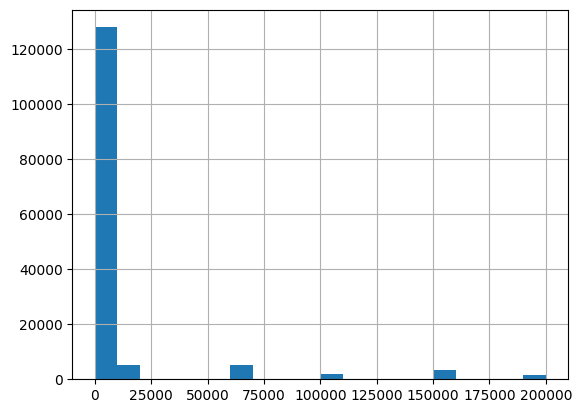

In [14]:
print('Распределение стоимости купленных туров в группе А:')
df_cor[df_cor['group'] == 'A']['price'].hist(bins=20, align='mid')

Распределение стоимости купленных туров чеков в группе B:


<AxesSubplot: >

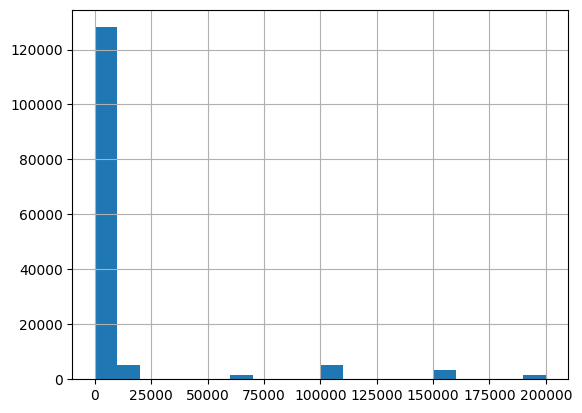

In [15]:
print('Распределение стоимости купленных туров чеков в группе B:')
df_cor[df_cor['group'] == 'B']['price'].hist(bins=20, align='mid')

In [16]:
pd.set_option('display.max_rows', 10)
print('Распределение стоимости купленных туров чеков в группе A (количество):') 
display(df_cor[df_cor['group'] == 'A']['price'].value_counts())
print('Распределение стоимости купленных туров чеков в группе B (количество):')
display(df_cor[df_cor['group'] == 'B']['price'].value_counts())
print('Распределение стоимости купленных туров чеков в группе A (%):')
display(df_cor[df_cor['group'] == 'A']['price'].value_counts(normalize=True))
print('Распределение стоимости купленных туров чеков в группе B (%):')
display(df_cor[df_cor['group'] == 'B']['price'].value_counts(normalize=True))

Распределение стоимости купленных туров чеков в группе A (количество):


0         127820
60000       5271
10000       5182
150000      3478
100000      1832
200000      1724
Name: price, dtype: int64

Распределение стоимости купленных туров чеков в группе B (количество):


0         128091
100000      5227
10000       5201
150000      3438
60000       1730
200000      1694
Name: price, dtype: int64

Распределение стоимости купленных туров чеков в группе A (%):


0         0.879655
60000     0.036275
10000     0.035662
150000    0.023936
100000    0.012608
200000    0.011865
Name: price, dtype: float64

Распределение стоимости купленных туров чеков в группе B (%):


0         0.881071
100000    0.035954
10000     0.035775
150000    0.023648
60000     0.011900
200000    0.011652
Name: price, dtype: float64

Посмотрим более детально на диаграммы распределения стоимости купленных туров без учета визитов, не закончившихся покупкой:

Распределение стоимости купленных туров в группе А (без учета визитов, не приведших к покупке):


<AxesSubplot: >

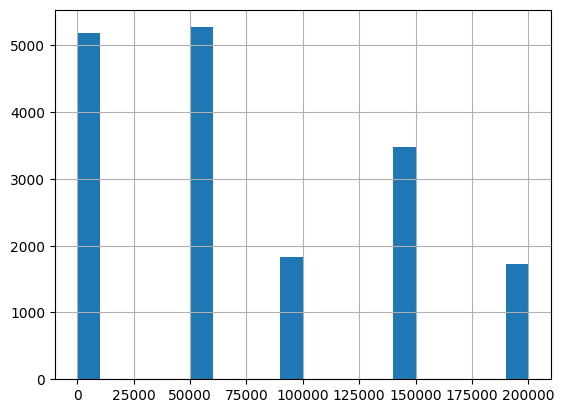

In [17]:
print('Распределение стоимости купленных туров в группе А (без учета визитов, не приведших к покупке):')
df_cor[df_cor['group'] == 'A']['price'].hist(bins=20, align='mid', range=(1,200000))

Распределение стоимости купленных туров в группе B (без учета визитов, не приведших к покупке):


<AxesSubplot: >

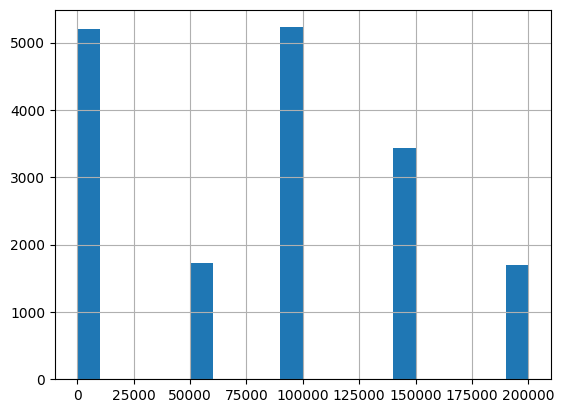

In [18]:
print('Распределение стоимости купленных туров в группе B (без учета визитов, не приведших к покупке):')
df_cor[df_cor['group'] == 'B']['price'].hist(bins=20, align='mid', range=(1,200000))

In [19]:
hist_df = pd.DataFrame(df_cor[df_cor['group'] == 'A']['price'].value_counts(normalize=True))
hist_df = hist_df.join(pd.DataFrame(df_cor[df_cor['group'] == 'B']['price'].value_counts(normalize=True)), \
    lsuffix='_A', rsuffix='_B')
hist_df.sort_index(inplace=True)
hist_df.reset_index(inplace=True)
hist_df.rename(columns={'index':'price', 'price_A':'%_in_group_A', 'price_B':'%_in_group_B'}, inplace=True)
hist_df['%_in_group_A'] = hist_df['%_in_group_A'].apply(lambda x : round(x,3))
hist_df['%_in_group_B'] = hist_df['%_in_group_B'].apply(lambda x : round(x,3))
print('Распределение стоимости купленных туров в группах:')
display(hist_df)

Распределение стоимости купленных туров в группах:


,price,%_in_group_A,%_in_group_B
0,0,0.880,0.881
1,10000,0.036,0.036
2,60000,0.036,0.012
3,100000,0.013,0.036
4,150000,0.024,0.024
5,200000,0.012,0.012


**ВЫВОД:** Распределения стоимости купленных туров в группах А и В очень похожи. Единственное существенное отличие - в группе А туры за 60000 рублей предпочитают турам за 100000 рублей, а в группе В - зеркально наоборот. В остальном распределение покупок по стоимости в группах совпадает вплоть до 100-ой доли процента. 

## Рассчитаем кумулятивные метрики в группах

In [20]:
pd.set_option('display.max_rows', 4)
print('Таблица без пользователей, попавших в обе группы:')
display(df_cor)

Таблица без пользователей, попавших в обе группы:


,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
...,...,...,...,...,...
294476,697314,2021-01-15,A,0,0
294477,715931,2021-01-16,B,0,0


In [21]:
def cummulative_table(data): # В переменную data будем передавать название переменной датафейма
    df_cumm = [] # Создаём пустой список
    for i in data['date'].unique(): # Запускаем цикл по каждому отдельному значению даты
        out = data[data['date'] <= i].groupby('group') \
               .agg({'date':'max', 'user_id':'count', 'purchase':'sum', 'price':'sum'})
        df_cumm.append(out) # Полученный срез добавляем в созданный ранее список
    return pd.concat(df_cumm).reset_index() # Объединяем списки и возвращаем результат

cumm=cummulative_table(df_cor)
cumm.rename(columns=({'user_id':'user_sessions_cnt','purchase':'purchases_cnt','price':'price_total'}),inplace=True)
#display(cumm)
#display(cumm['user_sessions_cnt'].max())
cumm.sort_values(by=['date','group'],  ignore_index=True, inplace= True)   
print('Таблица с кумулятивными метриками (накопленным итогом)\n - числом сессий, покупок, суммарной стоимостью покупок:')
display(cumm)

Таблица с кумулятивными метриками (накопленным итогом)
 - числом сессий, покупок, суммарной стоимостью покупок:


,group,date,user_sessions_cnt,purchases_cnt,price_total
0,A,2021-01-02,2854,359,29410000
1,B,2021-01-02,2861,345,29660000
...,...,...,...,...,...
44,A,2021-01-24,145307,17487,1417780000
45,B,2021-01-24,145381,17290,1533010000


In [22]:
cumm['avg_price'] = cumm['price_total'] / cumm['purchases_cnt']
cumm['conversion, %'] = round(cumm['purchases_cnt'] / cumm['user_sessions_cnt'] * 100, 2)
print('Таблица с кумулятивными метриками (накопленным итогом)\n - числом сессий, покупок, суммарной стоимостью покупок, средним чеком и конверсией:')
pd.set_option('display.max_rows', 50)
display(cumm)

Таблица с кумулятивными метриками (накопленным итогом)
 - числом сессий, покупок, суммарной стоимостью покупок, средним чеком и конверсией:


,group,date,user_sessions_cnt,purchases_cnt,price_total,avg_price,"conversion, %"
0,A,2021-01-02,2854,359,29410000,81922.005571,12.58
1,B,2021-01-02,2861,345,29660000,85971.014493,12.06
2,A,2021-01-03,9450,1107,91410000,82574.525745,11.71
3,B,2021-01-03,9480,1099,95620000,87006.369427,11.59
4,A,2021-01-04,16016,1906,155660000,81668.415530,11.90
5,B,2021-01-04,16016,1863,163650000,87842.190016,11.63
6,A,2021-01-05,22449,2696,220210000,81680.267062,12.01
7,B,2021-01-05,22527,2612,227200000,86983.154671,11.59
8,A,2021-01-06,29055,3460,283620000,81971.098266,11.91
9,B,2021-01-06,29278,3450,302220000,87600.000000,11.78


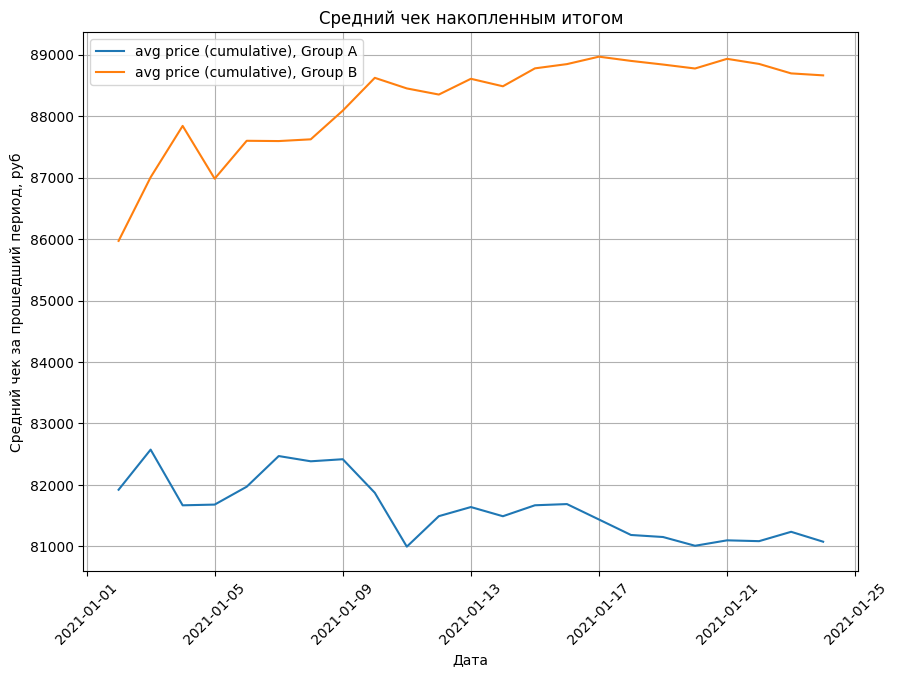

In [23]:
plt.figure(figsize=(10,7)) 
plt.plot(cumm[cumm['group']=='A']['date'], cumm[cumm['group']=='A']['avg_price'], label='avg price (cumulative), Group A') 
plt.plot(cumm[cumm['group']=='B']['date'], cumm[cumm['group']=='B']['avg_price'], label='avg price (cumulative), Group B')
plt.title('Средний чек накопленным итогом') 
plt.xlabel('Дата') 
plt.ylabel('Средний чек за прошедший период, руб') 
plt.xticks(rotation = 45) 
plt.legend() 
plt.grid(True) 
plt.show() 


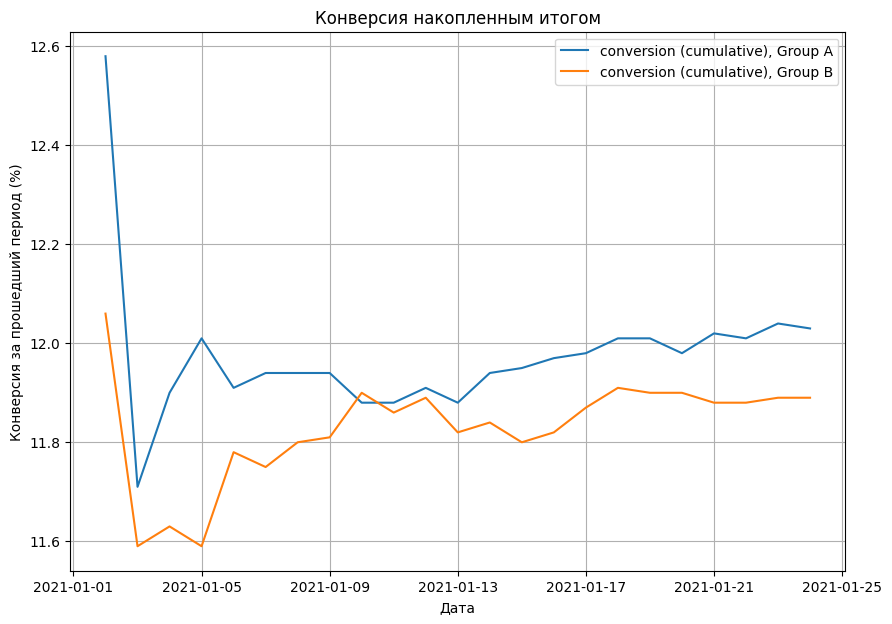

In [24]:
plt.figure(figsize=(10,7)) 
plt.plot(cumm[cumm['group']=='A']['date'], cumm[cumm['group']=='A']['conversion, %'], label='conversion (cumulative), Group A') 
plt.plot(cumm[cumm['group']=='B']['date'], cumm[cumm['group']=='B']['conversion, %'], label='conversion (cumulative), Group B')
plt.title('Конверсия накопленным итогом') 
plt.xlabel('Дата') 
plt.ylabel('Конверсия за прошедший период (%)') 
#plt.xticks(rotation = 45) 
plt.legend() # 
plt.grid(True) 
plt.show() 

**ВЫВОД:** После колебаний в первые дни периода, кумулятивные средний чек и конверсия достаточно стабилизировались. В результате конверсия группы А стабильно выше группы B. Но средний чек группы B выше среднего чека группы А. 

## Проверка гипотез

### Гипотеза о равенстве конверсии в группах
- нулевая гипотеза - конверсии в обеих группах равны
- альтернативная гипотеза - конверсии в группах не равны 

Посмотрим какова форма распределения показателя конверсии по дням в группах:

In [25]:
conv2=df_cor.groupby(['group','date'],as_index=False).aggregate({'user_id':'count','purchase':'sum','price':'sum'}) \
    .rename(columns={'user_id':'sessions_cnt','purchase':'purchases_cnt','price':'total_price'})
print('Число сессий, покупок и суммарная стоимость покупок по дням по группам:')
pd.set_option('display.max_rows', 4)
display(conv2)

Число сессий, покупок и суммарная стоимость покупок по дням по группам:


,group,date,sessions_cnt,purchases_cnt,total_price
0,A,2021-01-02,2854,359,29410000
1,A,2021-01-03,6596,748,62000000
...,...,...,...,...,...
44,B,2021-01-23,6633,805,68930000
45,B,2021-01-24,3677,442,38650000


In [26]:
conv2['converse_%'] = round(conv2['purchases_cnt'] / conv2['sessions_cnt'] * 100, 2)
conv2['price_avg'] = conv2['total_price'] / conv2['purchases_cnt']
print('Количество сессий, количество покупок, общая стоимость покупок,\nконверсия и стоимость среднего чека по дням по группам:')
display(conv2)

Количество сессий, количество покупок, общая стоимость покупок,
конверсия и стоимость среднего чека по дням по группам:


,group,date,sessions_cnt,purchases_cnt,total_price,converse_%,price_avg
0,A,2021-01-02,2854,359,29410000,12.58,81922.005571
1,A,2021-01-03,6596,748,62000000,11.34,82887.700535
...,...,...,...,...,...,...,...
44,B,2021-01-23,6633,805,68930000,12.14,85627.329193
45,B,2021-01-24,3677,442,38650000,12.02,87443.438914


Диаграмма распределения показателя конверсии в группе А:


<AxesSubplot: >

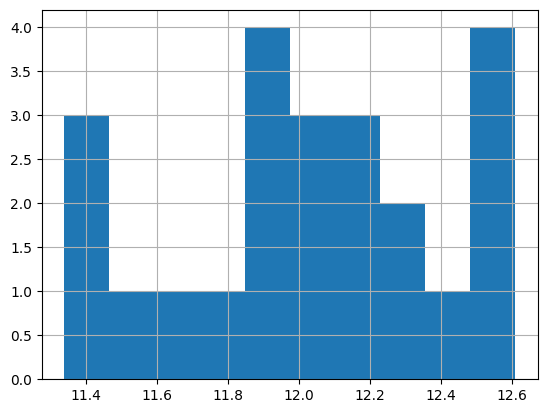

In [27]:
print('Диаграмма распределения показателя конверсии в группе А:')
conv2[conv2['group']=='A']['converse_%'].hist()

Диаграмма распределения показателя конверсии в группе B:


<AxesSubplot: >

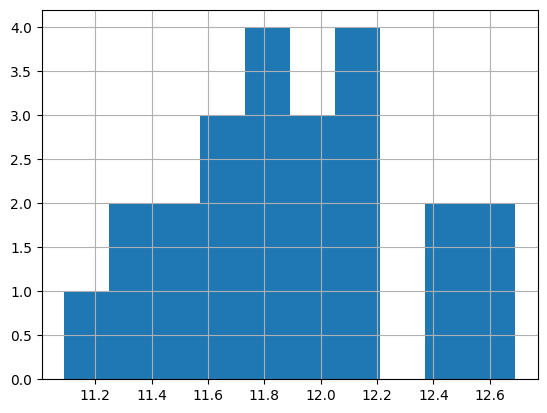

In [28]:
print('Диаграмма распределения показателя конверсии в группе B:')
conv2[conv2['group']=='B']['converse_%'].hist()

ВЫВОД: Будем считать распределение показателя конверсии в обеих группах приблизительно нормальным.

 Проверим гипотезу о равенстве конверсии в группах при помощи Z-теста:

Импортируем дополнительные библиотеки для проверки гипотез:

In [29]:
from scipy import stats as st
import numpy as np
import math as mth

In [30]:
print('Показатели по группам - количество сессий, количество покупок, общая стоимость покупок,\nконверсия и стоимость среднего чека:')
display(conv)

Показатели по группам - количество сессий, количество покупок, общая стоимость покупок,
конверсия и стоимость среднего чека:


,group,sessions_cnt,purchases_cnt,total_price,converse,price_avg
0,A,145307,17487,1417780000,12.03,81076.23
1,B,145381,17290,1533010000,11.89,88664.55


In [31]:
p1 = conv[conv['group']=='A']['purchases_cnt'].sum() / conv[conv['group']=='A']['sessions_cnt'].sum() 
p2 = conv[conv['group']=='B']['purchases_cnt'].sum() / conv[conv['group']=='B']['sessions_cnt'].sum() 
p = conv['purchases_cnt'].sum() / conv['sessions_cnt'].sum()	                
p_diff = p1 - p2
z = p_diff / mth.sqrt( \
    p * (1 - p) * (1/conv[conv['group']=='A']['sessions_cnt'].sum() + 1/conv[conv['group']=='B']['sessions_cnt'].sum()))  
distr = st.norm(0, 1)
p_val = (1 - distr.cdf(abs(z))) * 2
print('P-value :   ', p_val)

P-value :    0.23940749849829834


**ВЫВОД**  
P-value больше принятого уровня значимости (0,05), следовательно, статистически значимая разница между конверсией в группе A и конверсией в группе B отсутствует - конверсию можно считать одинаковой в обеих группах. 

### Гипотеза о равенстве выручки от групп
- нулевая гипотеза - выручка от групп одинакова
- альтернативная гипотеза - выручка от групп разная

Посмотрим какова форма распределения показателя выручки от пользователей двух групп:

In [32]:
print('Таблица сессий без пользователей, попавших в обе группы:')
display(df_cor)

Таблица сессий без пользователей, попавших в обе группы:


,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
...,...,...,...,...,...
294476,697314,2021-01-15,A,0,0
294477,715931,2021-01-16,B,0,0


Диаграмма распределения показателя выручки от пользователей из группы A:


<AxesSubplot: >

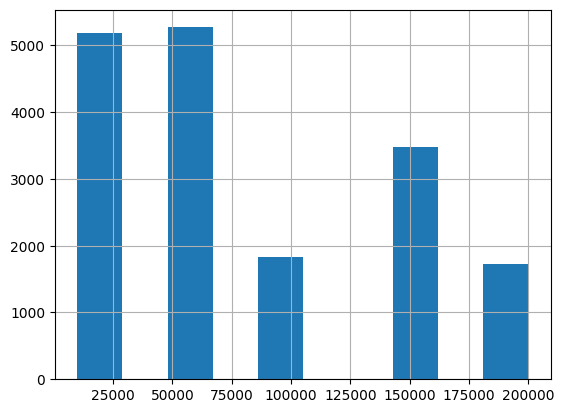

In [33]:
print('Диаграмма распределения показателя выручки от пользователей из группы A:')
df_cor[(df_cor['group']=='A')&(df_cor['price']>0)]['price'].hist()

Диаграмма распределения показателя выручки от пользователей из группы B:


<AxesSubplot: >

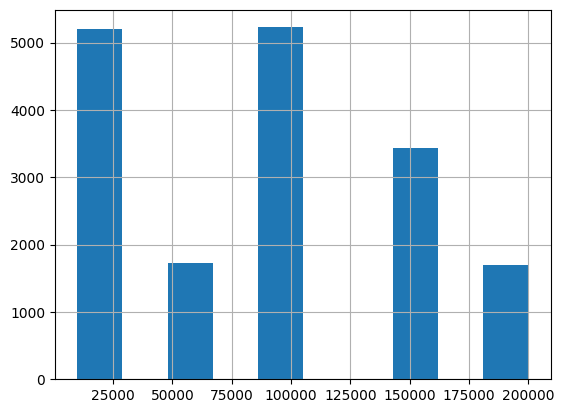

In [34]:
print('Диаграмма распределения показателя выручки от пользователей из группы B:')
df_cor[(df_cor['group']=='B')&(df_cor['price']>0)]['price'].hist()

ВЫВОД: Распределение показателя выручки от пользователей обеих групп не является нормальным.

 Проверим гипотезу о равенстве выручки в группах при помощи теста Манна-Уитни:

In [35]:
results =  st.mannwhitneyu( \
    df_cor[(df_cor['group']=='A') & (df_cor['price']>0)]['price'] \
        , df_cor[(df_cor['group']=='B') & (df_cor['price']>0)]['price'])
print(results)

MannwhitneyuResult(statistic=139547139.0, pvalue=2.825361345286736e-37)


**ВЫВОД**  
P-value меньше принятого уровня значимости (0,05), следовательно имеется статистически значимая разница между выручкой от пользователей разных групп - выручка в группе B отличается от выручки в группе А. 

### Гипотеза о равенстве средних чеков в группах по дням
- нулевая гипотеза - средний чек одинаков
- альтернативная гипотеза - средний чек в разных группах разный

In [36]:
print('Количество сессий, количество покупок, общая стоимость покупок,\nконверсия и стоимость среднего чека по дням по группам:')
display(conv2)

Количество сессий, количество покупок, общая стоимость покупок,
конверсия и стоимость среднего чека по дням по группам:


,group,date,sessions_cnt,purchases_cnt,total_price,converse_%,price_avg
0,A,2021-01-02,2854,359,29410000,12.58,81922.005571
1,A,2021-01-03,6596,748,62000000,11.34,82887.700535
...,...,...,...,...,...,...,...
44,B,2021-01-23,6633,805,68930000,12.14,85627.329193
45,B,2021-01-24,3677,442,38650000,12.02,87443.438914


Диаграмма распределения стоимости среднего чека за день в группе A:


<AxesSubplot: >

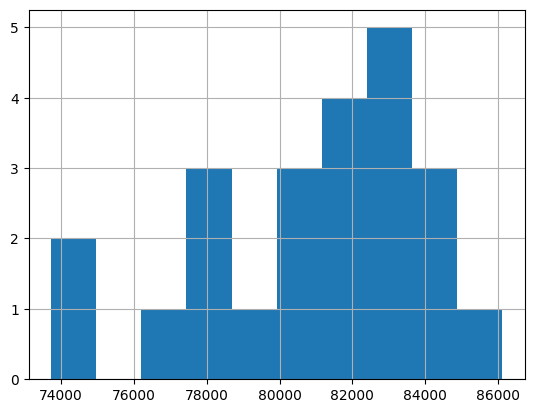

In [37]:
print('Диаграмма распределения стоимости среднего чека за день в группе A:')
conv2[conv2['group']=='A']['price_avg'].hist()

Диаграмма распределения стоимости среднего чека за день в группе B:


<AxesSubplot: >

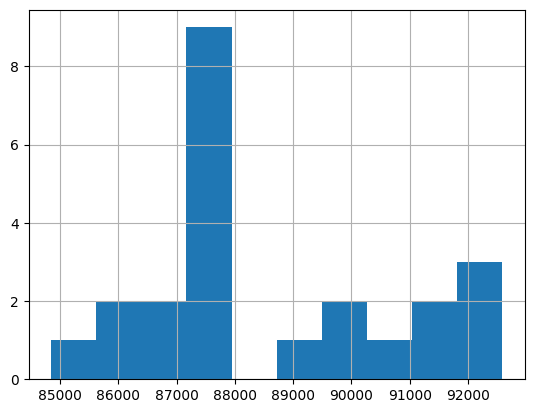

In [38]:
print('Диаграмма распределения стоимости среднего чека за день в группе B:')
conv2[conv2['group']=='B']['price_avg'].hist()

ВЫВОД: Будем считать распределение среднего чека за день в обеих группах приблизительно нормальным.

 Проверим гипотезу о равенстве стоимости среднего чека за день в группах при помощи T-теста:

In [39]:
res = st.ttest_ind( conv2[conv2['group']=='A']['price_avg'], conv2[conv2['group']=='B']['price_avg'] )
print(res)

Ttest_indResult(statistic=-9.609061044565284, pvalue=2.2523589349617907e-12)


**ВЫВОД**  
P-value меньше принятого уровня значимости (0,05), следовательно имеется статистически значимая разница между стоимостью среднего чека за день в разных группах - средние чеки за день отличаются. 

## Подытожим выводы.  
- Результат предварительного анализа данных - в целом данные, полученные в ходе проведенного теста можно считать корректными и подлежащими дальнейшему анализу (подробности представлены выше, в соответствующем разделе).
- Распределения стоимости купленных туров в группах А и В очень похожи. Единственное существенное отличие - в группе А туры за 60000 рублей предпочитают турам за 100000 рублей, а в группе В - зеркально наоборот. В остальном распределение покупок по стоимости в группах совпадает вплоть до 100-ой доли процента. 
- После колебаний в первые дни периода, кумулятивные средний чек и конверсия достаточно стабилизировались. В результате конверсия группы А стабильно выше группы B. Но средний чек группы B выше среднего чека группы А. 
- **Конверсия:** Статистически значимая разница между конверсией в группе A и конверсией в группе B отсутствует - конверсию можно считать одинаковой в обеих группах. Для оценки использовался Z-тест, уровень значимости - 0,05.
- **Выручка:** Имеется статистически значимая разница между выручкой от пользователей разных групп - выручка в группе B больше выручки в группе А. Для оценки использовался Манна-Уитни, уровень значимости - 0,05.
- **Средний чек по дням:** Имеется статистически значимая разница между стоимостью среднего чека за день в разных группах - средний чек в группе B больше среднего чека в группе А. Для оценки использовался T-тест, уровень значимости - 0,05.

**ИТОГО:** Несмотря на то что конверсия группы B ниже, статистической значимости в конверсии не достигнуто, соответственно, считать конверсии разными оснований нет. При этом средний чек группы B выше среднего чека группы A (статистическая значимость достигнута) и вариант сайта B приносит значимо больше выручки, чем вариант сайта A.